# Test gyroscope implementation in Gym

## 1. Test environment class

### 1.1 Import and load environment

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp

In [2]:
'''
Difference with GyroscopeEnvV1:
-- dx_dt function now consider also the dynamics of disk, that is, disk speed is not constant
-- T3 is computed by PI controller: u3 = 0.09*(w_ref-w) w in [rpm], same as that in LabVIEW
-- Randomize inertia and friction constants, always consider friction
-- add measurement noise
'''

import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp


class GyroscopeRobustEnv(gym.Env):

    """
    GyroscopeEnv:
        GyroscopeEnv is a GYM environment for Quanser 3-DOF gyroscope. The gyroscope consists of a disk mounted 
        inside an inner gimbal which in turn is mounted inside an outer gimbal.
        The two gimbals are controlled by a RL controller, and the disk is controlled by a PID controller.
    
    State: 
        state = [x1, x2, x3, x4, x1_ref, x3_ref, w] (7 dimensions)
        Outer red gimbal:
            x1, or theta: angular position [rad]
            x2, or dot(theta): angular velocity [rad/s]
            x1_ref: angular position reference [rad]
            u1: motor voltage [V]
        Inner blue gimbal:
            x3, or phi: angular position [rad]
            x4, or dot(phi): angular velocity [rad/s]
            x3_ref: angular position reference [rad]
            u2: motor voltage [V]
        Golden disk:
            w: angular velocity [rad/s]
            u3: motor voltage [V]
        Mechanical constraints:
            motor voltage: [-10, 10] [V]
            gimbal velocity: [-100, 100] [rpm]
            disk velocity: [-300, 300] [rpm]
    
    Observation:
        observation = [cos(x1), sin(x1), x2, cos(x3), sin(x3), x4, x1_ref, x3_ref, w] (9 dimensions)
        The angles have been replaced with their cosine and sine to prevent the discontinuity at -pi and pi.
        The observation space is thus larger than the state space.
        
    Action:
        action = [a1, a2]
        Note: a1, a2 are normalized voltages
              u1, u2 = 10*a1, 10*a2 are actual voltages
              T1, T2 = KtotRed*u1, KtotBlue*u2 are motor torques
        
    Initialization:
        Some versions of Gym may not support initialization with arguments, so initialize it manully with: 
        # create env
        env = GyroscopeEnv()
        env.init(simu_args = simu_args, reward_func = reward_func, reward_args = reward_args)
        # simu_args, with optional simulation step (dt), episode length (ep_len), and random seed (seed)
        simu_args = {'dt': 0.05, 'ep_len': 100, 'seed': 2}
        # reward_func, optional reward function, default value is 'Quadratic'
        reward_func = 'Quadratic'
        # reward_args, optional reward parameters
        reward_args = {'qx1': 1, 'qx2': 0.01, 'qx3': 1, 'qx4': 0.01, 'pu1': 0, 'pu2': 0}
    """
    
    # ---------------------------------------------------------------------------------------------------- #
    # ------------------------------------------ Initialization ------------------------------------------ #
    # ---------------------------------------------------------------------------------------------------- #        
                
    def init(self, simu_args = {}, reward_func = 'Quadratic', reward_args = {}):
        
        # Initialize mechanical parameters of the gyroscope
        self.init_gyro()

        # Initialize simulation parameters
        self.init_simu(**simu_args)
        
        # Initialize reward parameters
        self.init_reward(reward_func, reward_args)
        
        # State space, 7D
        self.state_bound = np.array([self.maxAngle, self.maxGimbalSpeed, self.maxAngle, self.maxGimbalSpeed, 
                                   self.maxAngle, self.maxAngle, self.maxDiskSpeed], dtype = np.float32)
        self.state_space = spaces.Box(low = -self.state_bound, high = self.state_bound, dtype = np.float32)
        
        # Observation space (normalized), 9D
        self.observation_bound = np.array([1.0] * 9, dtype = np.float32) 
        self.observation_space = spaces.Box(low = -self.observation_bound, high = self.observation_bound, 
                                            dtype = np.float32)
        
        # Action space (normalized), 2D
        self.action_bound = np.array([1.0] * 2, dtype = np.float32) 
        self.action_space = spaces.Box(low = -self.action_bound, high = self.action_bound, dtype = np.float32)
    
        # Randomize constants
        self.reset()
        
    # Initialize fixed parameters of the gyroscope
    def init_gyro(self):
        
        # Inertias mean in Kg*m2, from SP report page 23, table 2
        self.Jrx1_m = 0.0179
        self.Jbx1_m = 0.0019
        self.Jbx2_m = 0.0008
        self.Jbx3_m = 0.0012
        self.Jdx1_m = 0.0028
        self.Jdx3_m = 0.0056

        # Inertia standard deviation
        self.Jrx1_s = 0.25*self.Jrx1_m
        self.Jbx1_s = 0.25*self.Jbx1_m
        self.Jbx2_s = 0.25*self.Jbx2_m
        self.Jbx3_s = 0.25*self.Jbx3_m
        self.Jdx1_s = 0.25*self.Jdx1_m
        self.Jdx3_s = 0.25*self.Jdx3_m

        # Friction parameter range
        self.fvr_r = [0,0.01]
        self.fcr_r = [0,0.01]
        self.fvb_r = [0,0.01]
        self.fcb_r = [0,0.01]

        # Gimbal motor constants, from SP report page 23, table 1
        # FAULHABER 3863-048 CR Coreless DC motors
        # NOTE!!!
        # The parameter Ktorque is wrong here, according to datasheet it should be 0.0797
        # The bad news is that it is too late to change it now so we leave it there
        # The good news it that RL will learn this from real data
        self.Kamp = 0.5 # current gain, A/V
        self.Ktorque = 0.0704 # motor gain, Nm/A
        self.eff = 0.86 # motor efficiency
        self.nRed = 1.5 # red gearbox eatio
        self.nBlue = 1 # blue gearbox eatio
        self.KtotRed = self.Kamp * self.Ktorque * self.eff * self.nRed # Nm/V
        self.KtotBlue = self.Kamp * self.Ktorque * self.eff * self.nBlue # Nm/V

        # Disk motor constants
        # FAULHABER 3863-048 CR Coreless DC motors
        self.KtotDisk = 0.5 * 0.0704 * 0.84 * 1 # Nm/V

        # Mechanical constraints
        self.maxVoltage = 10 # V
        self.maxAngle = np.pi # rad
        self.maxGimbalSpeed = 100 * 2 * np.pi / 60 # rad/s
        self.maxDiskSpeed = 300 * 2 * np.pi / 60 # rad/s
        
    # Initialize simulation parameters
    def init_simu(self, dt = 0.05, ep_len = 100, seed = 2, obs_noise = 0):

        # Time step in s
        self.dt = dt
        self.eval_per_dt = int(dt / 0.01) # run evaluation every 0.01s
        
        # Episode length and current episode
        self.ep_len = ep_len
        self.ep_cur = 0
        
        # Seed for random number generation
        self.seed(seed)
        self.viewer = None

        # Observation noise
        self.obs_noise = obs_noise

        # Gyroscope state and observation
        self.state = np.array([0] * 7)
        self.observe()
        
    # Initialize reward parameters
    def init_reward(self, reward_func, reward_args):
                
        reward_dict = {
            # continuous reward functions, part one
            'Quadratic': self.quad_reward,
            'Quadratic with bonus':self.quad_bon_reward,
            'Quadratic with exponential': self.quad_exp_reward,
            'Quadratic with ending penalty': self.quad_end_pen_reward,
            'Quadratic with penalty': self.quad_pen_reward,
            'Absolute': self.abs_reward,
            'Normalized': self.norm_reward,
            'Normalized with bonus': self.norm_bon_reward,
            # continuous reward functions, part two
            'Power':self.power_reward,
            'Exponential': self.exp_reward,
            'PE': self.power_exp_reward,
            # sparse reward functions
            'Sparse':self.sparse_reward,
            'Sparse with exp': self.sparse_reward_with_exp,
            'Sparse with exp 2': self.sparse_reward_with_exp_2
        }
        if reward_func in ['Sparse']: 
            self.sparse = True
        else:
            self.sparse = False
        self.reward_func = reward_dict[reward_func]
        self.reward_args = reward_args

    # ---------------------------------------------------------------------------------------------------- #
    # ----------------------------------------------- Step ----------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
    
    # Simulate the environment fot one step dt
    def step(self, a):
        
        # extract states and actions
        x1, x2, x3, x4, x1_ref, x3_ref, w = self.state
        a1, a2 = a
        u1, u2 = self.maxVoltage * a1, self.maxVoltage * a2

        # Increment episode
        self.ep_cur += 1

        # For quad_end_pen_reward, check if terminal state is reached
        if self.reward_func == self.quad_end_pen_reward and self.ep_cur == self.ep_len:
            self.reward_args['end_horizon'] = 1

        # run simulation for a step
        # we dont care about the position of disk, so set it to 0
        results = solve_ivp(
                    fun = self.dxdt, 
                    t_span = (0, self.dt), # solver starts with t = 0 and integrates until it reaches t = self.dt
                    y0 = [x1, x2, x3, x4, 0, w], # initial state
                    method = 'RK45', 
                    t_eval = np.linspace(0, self.dt, self.eval_per_dt), # times at which to store the computed solution
                    args = (u1, u2) 
                )
        
        # evaluated states, each contains eval_per_dt points
        x1_eval = results.y[0]
        x2_eval = results.y[1]
        x3_eval = results.y[2]
        x4_eval = results.y[3]
        w_eval = results.y[5]

        # change in velocity, or acceleration
        dx2 = x2_eval[-1] - x2
        dx4 = x4_eval[-1] - x4
        
        # keep only the last evaluation value
        x1 = x1_eval[-1]
        x2 = x2_eval[-1]
        x3 = x3_eval[-1]
        x4 = x4_eval[-1]
        w = w_eval[-1]
        
        # Angle error (normalized between pi and -pi to get smallest distance)
        x1_diff = self.angle_normalize(x1 - x1_ref)
        x3_diff = self.angle_normalize(x3 - x3_ref)
        
        # update state and observation
        self.state = np.array([x1, x2, x3, x4, x1_ref, x3_ref, w])
        self.observe()

        # Reward(float), normalized everything in advance
        reward = self.reward_func(x1_diff/self.maxAngle, x3_diff/self.maxAngle, 
                                  x2/self.maxGimbalSpeed, x4/self.maxGimbalSpeed, 
                                  dx2/self.maxGimbalSpeed, dx4/self.maxGimbalSpeed,
                                  a1, a2, **self.reward_args)
        
        # Done(bool): whether it’s time to reset the environment again.
        if self.sparse:
            # in sparse reward functions, terminate the episode when the speed is too large
            # otherwise the exploration will happen mainly in high speed area, which is not desired
            done = self.ep_cur > self.ep_len or x2 > 2*self.maxGimbalSpeed or x4 > 2 * self.maxGimbalSpeed
        else:
            # in other reward functions, terminating the episode early will encourage the agent to 
            # speed up the gyroscope and end the episode, because the reward is negative
            done = self.ep_cur > self.ep_len
        
        # Info(dict): diagnostic information useful for debugging. 
        info = {'state': self.state, 'observation': self.observation}
        
        return self.observation, reward, done, info
    
    # Compute the derivative of the state, here u is NOT normalized
    def dxdt(self, t, x, u1, u2):

        # J1, J2, J3, Jdx3 = self.J1, self.J2, self.J3, self.Jdx3
        Jbx1, Jbx2, Jbx3, Jrx1, Jdx1, Jdx3 = self.Jbx1, self.Jbx2, self.Jbx3, self.Jrx1, self.Jdx1, self.Jdx3

        # Convert input voltage to input torque
        T1, T2 = self.KtotRed * u1, self.KtotBlue * u2
        
        # Friction
        T1 = T1 - self.fvr*x[1] - self.fcr*np.sign(x[1])
        T2 = T2 - self.fvb*x[3] - self.fcb*np.sign(x[3])
        
        # Compute T3 with a PI controller (I = 0), same as what we have on the real gyroscope
        u3 = 0.09 * (self.w_ref - x[5]) / 2 / np.pi * 60 # 0.09 is for w in rpm
        # Add a noise to u3
        u3 = np.random.normal(u3, abs(0.2*u3))
        # Make sure it's in range [-10,10]
        u3 = np.clip(u3, -self.maxVoltage, self.maxVoltage)
        # voltage to torque
        T3 = self.KtotDisk * u3 

        # Equations of motion for constant omega
        # dx_dt = [0, 0, 0, 0]
        # dx_dt[0] = x[1]
        # dx_dt[1] = (T1+J1*np.sin(2*x[2])*x[1]*x[3]-Jdx3*np.cos(x[2])*x[3]*w)/(J2 + J1*np.power(np.sin(x[2]),2))
        # dx_dt[2] = x[3]
        # dx_dt[3] = (T2-J1*np.cos(x[2])*np.sin(x[2])*np.power(x[1],2)+Jdx3*np.cos(x[2])*x[1]*w)/J3
        
        # Equations of motion for varying omega
        # Note !!!
        # The equation in previous project is wrong
        dx_dt = [0, 0, 0, 0, 0, 0]
        dx_dt[0] = x[1]
        dx_dt[1] = ((2*Jbx1-2*Jbx3+2*Jdx1-Jdx3)*np.sin(2*x[2])*x[1]*x[3]+2*(T1-T3*np.sin(x[2])-Jdx3*np.cos(x[2])*x[3]*x[5]))/(Jbx1+Jbx3+Jdx1+2*Jrx1+(Jbx1-Jbx3+Jdx1)*np.cos(2*x[2]))
        dx_dt[2] = x[3]
        dx_dt[3] = (T2-(Jbx1-Jbx3+Jdx1-Jdx3)*np.cos(x[2])*np.sin(x[2])*np.power(x[1],2)+Jdx3*np.cos(x[2])*x[1]*x[5])/(Jbx2+Jdx1)
        dx_dt[4] = x[5]
        dx_dt[5] = ((Jbx1+Jbx3+Jdx1+Jdx3+2*Jrx1+(Jbx1-Jbx3+Jdx1-Jdx3)*np.cos(2*x[2]))*T3-2*Jdx3*T1*np.sin(x[2])+Jdx3*np.cos(x[2])*(-3*Jbx1+Jbx3-3*Jdx1+Jdx3-2*Jrx1+(Jbx1-Jbx3+Jdx1-Jdx3)*np.cos(2*x[2])*np.cos(2*x[2]))*x[1]*x[3]+Jdx3**2*np.sin(2*x[2])*x[3]*x[5])/(Jdx3*(Jbx1+Jbx3+Jdx1+2*Jrx1+(Jbx1-Jbx3+Jdx1)*np.cos(2*x[2])))

        return dx_dt
    
    # ---------------------------------------------------------------------------------------------------- #
    # ------------------------------------------ Reward Part I ------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
    
    def abs_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0):
        return -(qx1*abs(x1_diff) + qx3*abs(x3_diff) + qx2*abs(x2) + qx4*abs(x4) + pu1*abs(u1) + pu2*abs(u2))

    def norm_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, k = 0.2, qx2 = 0, qx4 = 0, pu1 = 0, pu2 = 0):
        return -((abs(x1_diff)/k)/(1 + (abs(x1_diff)/k)) + (abs(x3_diff)/k)/(1 + (abs(x3_diff)/k)) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2))

    def norm_bon_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, k = 0.2, qx2 = 0, qx4 = 0, pu1 = 0, pu2 = 0, bound = 0.001, bonus = 1):
        return -((abs(x1_diff)/k)/(1 + (abs(x1_diff)/k)) + (abs(x3_diff)/k)/(1 + (abs(x3_diff)/k)) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2)) + bonus*(abs(x1_diff) <= bound or abs(x3_diff) <= bound)

    def quad_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2))

    def quad_exp_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, eax1 = 10, ebx1 = 10, eax3 = 10, ebx3 = 10):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2) + eax1*(1-np.exp(-ebx1*(x1_diff**2))) + eax3*(1-np.exp(-ebx3*(x3_diff**2))))

    def quad_end_pen_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, sx1 = 10, sx3 = 10, end_horizon = 0):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2) + end_horizon*(sx1*(x1_diff**2)+sx3*(x3_diff**2)))

    def quad_pen_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, bound = 0.1, penalty = 50):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2)) - penalty*(abs(x1_diff) >= bound or abs(x3_diff) >= bound)

    def quad_bon_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 0.01, qx3 = 1, qx4 = 0.01, pu1 = 0, pu2 = 0, bound = 0.1, bonus = 5):
        return -(qx1*(x1_diff**2) + qx3*(x3_diff**2) + qx2*(x2**2) + qx4*(x4**2) + pu1*(u1**2) + pu2*(u2**2)) + bonus*(abs(x1_diff) <= bound or abs(x3_diff) <= bound)

    # ---------------------------------------------------------------------------------------------------- #
    # ------------------------------------------ Reward Part II ------------------------------------------ #
    # ---------------------------------------------------------------------------------------------------- #
    
    def power_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, p = 0.5):
        return -(qx1*abs(x1_diff)**p + qx3*abs(x3_diff)**p + qx2*abs(x2)**p + qx4*abs(x4)**p + pu1*abs(u1)**p + pu2*abs(u2)**p)
        
    def exp_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, e = 10):
        return -(qx1*(1-np.exp(-e*abs(x1_diff))) + qx3*(1-np.exp(-e*abs(x3_diff))) + qx2*(1-np.exp(-e*abs(x2))) + qx4*(1-np.exp(-e*abs(x4))) + pu1*(1-np.exp(-e*abs(u1))) + pu2*(1-np.exp(-e*abs(u2))))
    
    def power_exp_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, p = 0.1, e = 10):
        return -(qx1*abs(x1_diff)**p + qx3*abs(x3_diff)**p + qx2*abs(x2)**p + qx4*abs(x4)**p + pu1*abs(u1)**p + pu2*abs(u2)**p) -(qx1*(1-np.exp(-e*abs(x1_diff))) + qx3*(1-np.exp(-e*abs(x3_diff))) + qx2*(1-np.exp(-e*abs(x2))) + qx4*(1-np.exp(-e*abs(x4))) + pu1*(1-np.exp(-e*abs(u1))) + pu2*(1-np.exp(-e*abs(u2))))
    
    # ---------------------------------------------------------------------------------------------------- #
    # ------------------------------------------ Reward Part III ----------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
        
    def sparse_reward(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, bx = 0.01, rx = 1, bv = 0.01, rv = 0, bu = 0.01, ru = 0):
        r = 0
        if abs(x1_diff) <= bx and abs(x3_diff) <= bx:
            if abs(x2) <= bv and abs(x4) <= bv:
                r += rv
            if abs(dx2) <= bu and abs(dx4) <= bu:
                r += ru
            r += rx
        return r

    def sparse_reward_with_exp(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, e = 10, bound = 0.01, reward = 1):
        return -(qx1*(1-np.exp(-e*abs(x1_diff))) + qx3*(1-np.exp(-e*abs(x3_diff))) + qx2*(1-np.exp(-e*abs(x2))) + qx4*(1-np.exp(-e*abs(x4))) + pu1*(1-np.exp(-e*abs(u1))) + pu2*(1-np.exp(-e*abs(u2)))) + reward*(abs(x1_diff) <= bound and abs(x3_diff) <= bound)
    
    def sparse_reward_with_exp_2(self, x1_diff, x3_diff, x2, x4, dx2, dx4, u1, u2, qx1 = 1, qx2 = 1, qx3 = 1, qx4 = 1, pu1 = 0, pu2 = 0, e = 10, bound = 0.01, reward = 1):
        return -(qx1*(1-np.exp(-e*abs(x1_diff))) + qx3*(1-np.exp(-e*abs(x3_diff))) + qx2*(1-np.exp(-e*abs(x2))) + qx4*(1-np.exp(-e*abs(x4))) + pu1*(1-np.exp(-e*abs(u1))) + pu2*(1-np.exp(-e*abs(u2)))) + reward*(abs(x1_diff) <= bound) + reward*(abs(x3_diff) <= bound)
    
    # ---------------------------------------------------------------------------------------------------- #
    # ---------------------------------------------- Helper ---------------------------------------------- #
    # ---------------------------------------------------------------------------------------------------- #
    
    # reset system to a given or random initial state
    def reset(self, x_0 = None):
        
        # randomize parameters
        self.randomize()

        # reset state
        if x_0 is None:
            self.state = self.state_space.sample()
        else:
            self.state = x_0
        self.w_ref = self.state[-1]
        # update observation
        self.observe()
        # reset counter
        self.ep_cur = 0
        
        return self.observation
        
    def randomize(self):
        
        # Inertias in Kg*m2
        self.Jrx1 = np.random.normal(self.Jrx1_m, self.Jrx1_s)
        self.Jbx1 = np.random.normal(self.Jbx1_m, self.Jbx1_s)
        self.Jbx2 = np.random.normal(self.Jbx2_m, self.Jbx2_s)
        self.Jbx3 = np.random.normal(self.Jbx3_m, self.Jbx3_s)
        self.Jdx1 = np.random.normal(self.Jdx1_m, self.Jdx1_s)
        self.Jdx3 = np.random.normal(self.Jdx3_m, self.Jdx3_s)

        # Friction parameters
        self.fvr = np.random.uniform(self.fvr_r[0], self.fvr_r[1])
        self.fcr = np.random.uniform(self.fcr_r[0], self.fcr_r[1])
        self.fvb = np.random.uniform(self.fvb_r[0], self.fvb_r[1])
        self.fcb = np.random.uniform(self.fcb_r[0], self.fcb_r[1])

    # return normalized observation
    def observe(self):
        s = self.state
        self.observation = np.array([np.cos(s[0]), np.sin(s[0]), s[1]/self.maxGimbalSpeed, 
                                     np.cos(s[2]), np.sin(s[2]), s[3]/self.maxGimbalSpeed, 
                                     s[4]/self.maxAngle, s[5]/self.maxAngle, s[6]/self.maxDiskSpeed])
        # If obs_noise != 0, then add a observation noise
        if self.obs_noise:
            self.observation = np.random.normal(self.observation, self.obs_noise * np.abs(self.observation))
        return self.observation
    
    # Keep the angles between -lim and lim
    def angle_normalize(self, x, lim = np.pi):
        return ((x + lim) % (2 * lim)) - lim
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def render(self, mode='human'):
        return None

    def close(self):
        if self.viewer:
            
            self.viewer.close()
            self.viewer = None

### 1.2 Initialize the environment

In [3]:
# Initialization args
simu_args = {
    'dt': 0.05,
    'ep_len': 100,
    'seed': 2,
    'obs_noise': 0
}
reward_func = 'PE'
reward_args = {
    'qx1': 1, 
    'qx2': 0.2, 
    'qx3': 1, 
    'qx4': 0.2, 
    'pu1': 0.1, 
    'pu2': 0.1,
    'p': 0.1,
    'e': 40
}

# Create env
env = GyroscopeRobustEnv()
env.init(simu_args = simu_args, reward_func = reward_func, reward_args = reward_args)

### 1.3 Run tests with simply input

In [4]:
# Set initial state
x_0 = [0.5, 10, 0.5, 0, 0, 0, 200 * 2 * np.pi / 60]
observation = env.reset(x_0)

time = np.arange(0, 10, env.dt)
state_record = np.empty([len(time), len(x_0)])
reward_record = np.empty([len(time), 1])
action_record = np.empty([len(time), 2])

for i in range(len(time)):
    action = [0,0] 
    # action = env.action_space.sample()
    
    observation, reward, done, info = env.step(action)
    state_record[i] = env.state
    reward_record[i] = reward
    action_record[i] = action

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

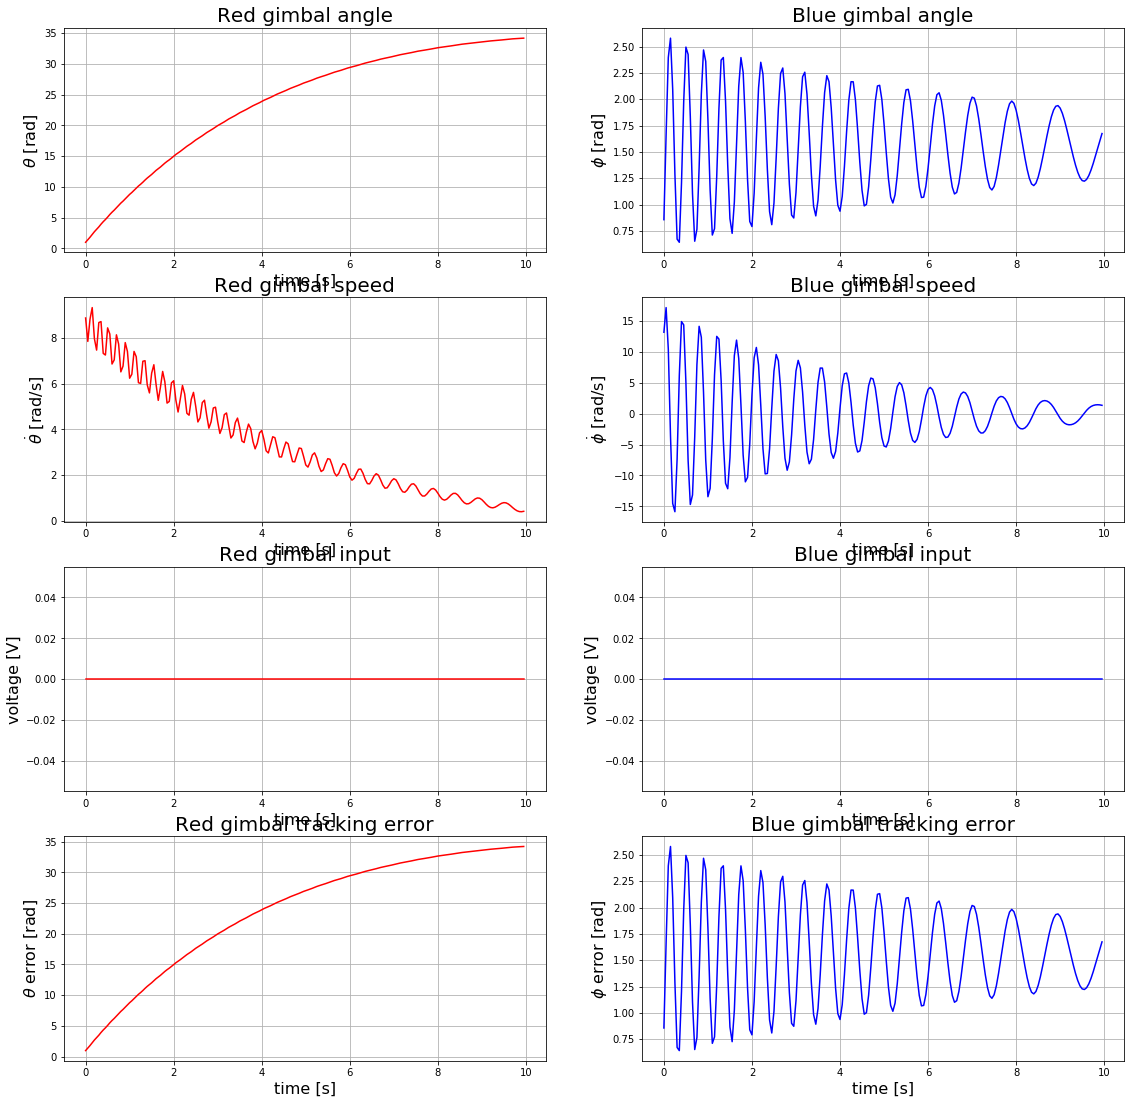

In [6]:
f, axs = plt.subplots(4,2,figsize=(19,19))

plt.subplot(4,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0],'r-')

plt.subplot(4,2,2)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2],'b-')

plt.subplot(4,2,3)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \theta$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,1],'r-')

plt.subplot(4,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\dot \phi$ [rad/s]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,3],'b-')

plt.subplot(4,2,5)
plt.title('Red gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,0]*10,'r-')

plt.subplot(4,2,6)
plt.title('Blue gimbal input',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('voltage [V]',fontsize=16)
plt.grid()
plt.plot(time,action_record[:,1]*10,'b-')

plt.subplot(4,2,7)
plt.title('Red gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\theta$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,0]-state_record[:,4],'r-')

plt.subplot(4,2,8)
plt.title('Blue gimbal tracking error',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel(r'$\phi$ error [rad]',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,2]-state_record[:,5],'b-')

plt.show()

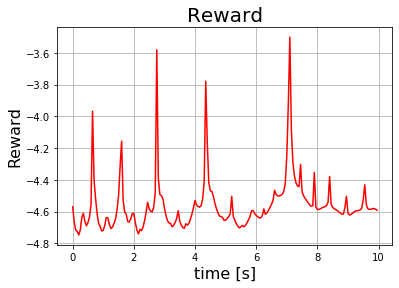

In [7]:
plt.title('Reward',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('Reward',fontsize=16)
plt.grid()
plt.plot(time,reward_record,'r-')

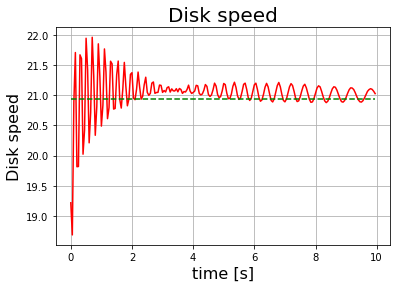

In [8]:
plt.title('Disk speed',fontsize=20)
plt.xlabel('time [s]',fontsize=16)
plt.ylabel('Disk speed',fontsize=16)
plt.grid()
plt.plot(time,state_record[:,-1],'r-')
plt.plot(time,np.full(len(time),env.w_ref), 'g--')